In [1]:
import alpdesign
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax.experimental import optimizers

### Initialize data

(-1.0, 1.0)

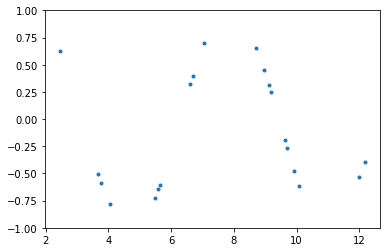

In [9]:
N = 32
x = np.linspace(0,4 * np.pi, 1000)
reps = x[np.random.randint(0,1000, size=N)].reshape(-1, 1)
labels = np.sin(reps)

rm_list = []
for i,value in enumerate(labels):
    if abs(value) > 0.80:
        rm_list.append(i)
        
reps = np.delete(reps, rm_list).reshape(-1, 1)
#print(reps)
labels = np.delete(labels, rm_list)
plt.plot(reps, labels, '.')
plt.ylim(-1,1)

In [10]:
print(len(reps))

20


In [11]:
def loop(key, reps, params):
    key, train_key = jax.random.split(key, num=2)
    labels = jnp.sin(reps)
    forward_t = hk.without_apply_rng(hk.transform(alpdesign.model_forward))
    params, losses = alpdesign.ensemble_train(train_key, forward_t, reps, labels, params=params, epochs=500)
    init_x = 6*jnp.abs(jax.random.normal(key, shape=(1, 1)))
    final_vec = alpdesign.mlp.bayes_opt(forward_t, params, init_x, labels)
    
    # plot
    forward = partial(forward_t.apply, params)
    yhat_mu, yhat_std = [], []
    x = np.linspace(0,4 * np.pi, 1000)
    for xi in x:
        v = alpdesign.model_reduce(forward(np.tile(xi, 5).reshape(-1, 1, 1)))
        yhat_mu.append(float(v[0]))
        yhat_std.append(float(v[1]))
    
    reps = jnp.concatenate((reps, final_vec))
    return key, reps, yhat_mu, yhat_std, final_vec, params
    
    

In [12]:

key = jax.random.PRNGKey(0)

yhat_mus = []
yhat_stds = []
final_vecs = []
repss = []
params = None
for i in range(10):
    print(i)
    key, reps, yhat_mu, yhat_std, final_vec, params= loop(key, reps, params)
    yhat_mus.append(yhat_mu)
    yhat_stds.append(yhat_std)
    final_vecs.append(final_vec)
    repss.append(reps)
    

0


/home/ziyue/miniconda3/envs/alpdesign/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3132: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


1
2
3
4
5
6
7
8
9


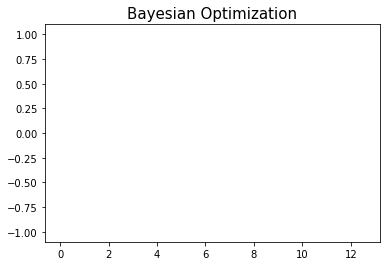

In [13]:
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)

for i in range(10):
    plt.plot(np.squeeze(repss[i]), np.sin(np.squeeze(repss[i])), 'o', color='C0')
    plt.plot(x, yhat_mus[i], color='C1')
    #print(x.shape)
    #print()
    plt.plot(final_vecs[i][0], jnp.sin(final_vecs[i][0]), 'o', color='C2',  marker=(5, 0))
    plt.errorbar(x, yhat_mus[i], yerr=yhat_stds[i], color='C1', alpha=0.1)
    plt.ylim(-1.1,1.1)
#     p = plt.pcolor(jnp.transpose(temp_logits_trace[i]), edgecolors='w', linewidths=1.5, cmap='Blues')
#     plt.yticks([0, 20])
#     plt.xticks([])
    plt.legend(['step %d' % (i)] , markerscale=0.1)
#     plt.xlabel('Position', fontsize=10)
#     plt.ylabel('Channel', fontsize=10)
    plt.title('Bayesian Optimization', fontsize=15)
    camera.snap()
animation = camera.animate(interval = 1000, repeat = True,
                           repeat_delay = 500)
animation.save('BO2.gif', writer = 'imagemagick', dpi=800)

In [3]:
key = jax.random.PRNGKey(0)
forward_t = hk.without_apply_rng(hk.transform(alpdesign.model_forward))
params, losses = alpdesign.ensemble_train(
    key, forward_t, reps, labels, epochs=500)

/home/ziyue/miniconda3/envs/alpdesign/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3132: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


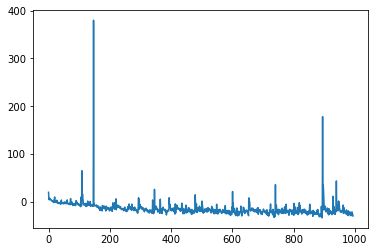

In [4]:
plt.plot(losses[5:])

In [5]:
forward = partial(forward_t.apply, params)
yhat_mu, yhat_std = [], []
for xi in x:
    v = alpdesign.model_reduce(forward(np.tile(xi, 5).reshape(-1, 1, 1)))
    yhat_mu.append(float(v[0]))
    yhat_std.append(float(v[1]))

In [10]:
def bayesian_ei(f, params, init_x, Y):
    out = f.apply(params, init_x)
    joint_out = alpdesign.model_reduce(out)
    mu = joint_out[0]
    std = joint_out[1]
    #mus = f.apply(params, X)[...,0]
    best = jnp.max(Y)
    epsilon = 0.1
    z = (mu-best-epsilon)/std
    return (mu-best-epsilon)*norm.cdf(z) + std*norm.pdf(z)


def bayes_opt(f, params, labels):
    key = jax.random.PRNGKey(2)
    key, _ = jax.random.split(key, num=2)
    eta = 1e-2
    n_steps = 500
    init_x = 12*jnp.abs(jax.random.normal(key, shape=(1, 1)))
    print(init_x)
    opt_init, opt_update, get_params = optimizers.adam(
        step_size=eta, b1=0.8, b2=0.9, eps=1e-5)
    opt_state = opt_init(init_x)

    @jax.jit
    def step(i, opt_state):
        x = get_params(opt_state)
        loss, g = jax.value_and_grad(alpdesign.mlp.bayesian_ei, 2)(
            f, params, x, labels)
        return opt_update(i, g, opt_state), loss

    for step_idx in range(n_steps):
        opt_state, loss = step(step_idx, opt_state)
        print(loss)

    final_vec = get_params(opt_state)
    return final_vec


In [11]:
final_vec = bayes_opt(forward_t, params, labels)

[[4.844677]]
0.009874584
0.009808234
0.009742238
0.009676664
0.009611484
0.009546691
0.009477924
0.009408293
0.0093366355
0.009248646
0.00914432
0.009040989
0.008938596
0.008837155
0.00873669
0.008637156
0.008537428
0.008437273
0.008338122
0.008239984
0.008142791
0.008046589
0.007951294
0.007856932
0.0077635073
0.0076646195
0.007560947
0.0074583367
0.0073568025
0.0072563253
0.0071569025
0.007058542
0.0069611957
0.006864915
0.006769648
0.006675382
0.0065821544
0.006489899
0.0063986764
0.0063084047
0.00621913
0.0061308085
0.006043463
0.0059570814
0.0058716293
0.0057871277
0.005703568
0.005620931
0.0055392073
0.005458414
0.005378523
0.0052995495
0.005221467
0.005144279
0.005067988
0.0049925614
0.0049180314
0.0048443666
0.004771569
0.0046996227
0.0046285447
0.004558309
0.004488927
0.0044203755
0.004352668
0.004284962
0.004217037
0.00414996
0.0040837456
0.0040183826
0.0039500035
0.0038809562
0.003812878
0.00374576
0.0036795852
0.0036143633
0.0035500764
0.0034866675
0.0034238508
0.0033617108

In [12]:
print(final_vec)

[[8.579401]]


(-1.0, 1.0)

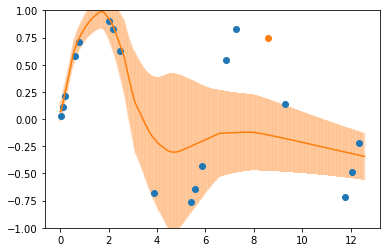

In [14]:
plt.plot(np.squeeze(reps), np.squeeze(labels), 'o')
plt.plot(x, yhat_mu, color='C1')
plt.plot(final_vec[0], jnp.sin(final_vec[0]), 'o')
plt.errorbar(x, yhat_mu, yerr=yhat_std, color='C1', alpha=0.1)
plt.ylim(-1,1)

In [17]:
reps = jnp.concatenate((reps, final_vec))
labels = jnp.sin(reps)

[[ 6.8555274 ]
 [12.33995   ]
 [ 5.5850534 ]
 [ 0.7924738 ]
 [11.761318  ]
 [ 5.4089484 ]
 [ 9.283265  ]
 [ 0.61636853]
 [ 2.0252109 ]
 [ 0.0251579 ]
 [12.063212  ]
 [ 5.8366327 ]
 [ 7.258054  ]
 [ 0.21384214]
 [ 2.1635792 ]
 [ 2.4654741 ]
 [ 0.11321054]
 [ 3.8868954 ]
 [ 8.579401  ]]
